In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch

from depth_anything_v2.dpt import DepthAnythingV2

from gkmo_utils import show_rgbd, get_sorted_files

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

xFormers not available
xFormers not available


In [2]:
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vitl' # or 'vits', 'vitb', 'vitg'

In [3]:
model = DepthAnythingV2(**model_configs[encoder])
model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_{encoder}.pth', map_location='cpu'))
model = model.to(DEVICE).eval()

In [4]:
raw_img = cv2.imread('input_teste/00019_00183_indoors_000_010.png')
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
depth = model.infer_image(raw_img) # HxW raw depth map in numpy
depth = 1/depth
depth_normalized = (depth - depth.min()) / (depth.max() - depth.min())

---- Depth Report ----

Unique values: [0.0000000e+00 9.9662168e-07 2.9014275e-06 ... 9.9996442e-01 9.9998790e-01
 1.0000000e+00]
how many uniques: 769868
Max: 1.0
Min: 0.0
shape: (768, 1024)
Has nan: False
Dtype: float32


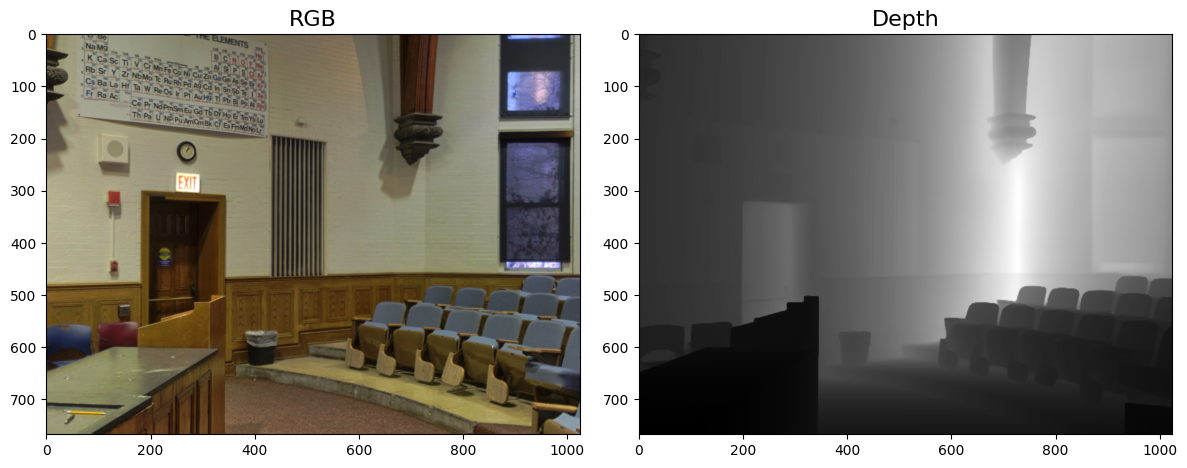

In [5]:
show_rgbd(depth_normalized, raw_img, figsize=(12,6))

In [6]:
groundtruth = np.load("input_teste/00019_00183_indoors_000_010_depth.npy")
mask = np.load("input_teste/00019_00183_indoors_000_010_depth_mask.npy")

---- Depth Report ----

Unique values: [ 0.         0.9640641  0.9653691 ... 17.118383  17.59613   17.830606 ]
how many uniques: 696292
Max: 17.83060646057129
Min: 0.0
shape: (768, 1024)
Has nan: False
Dtype: float32


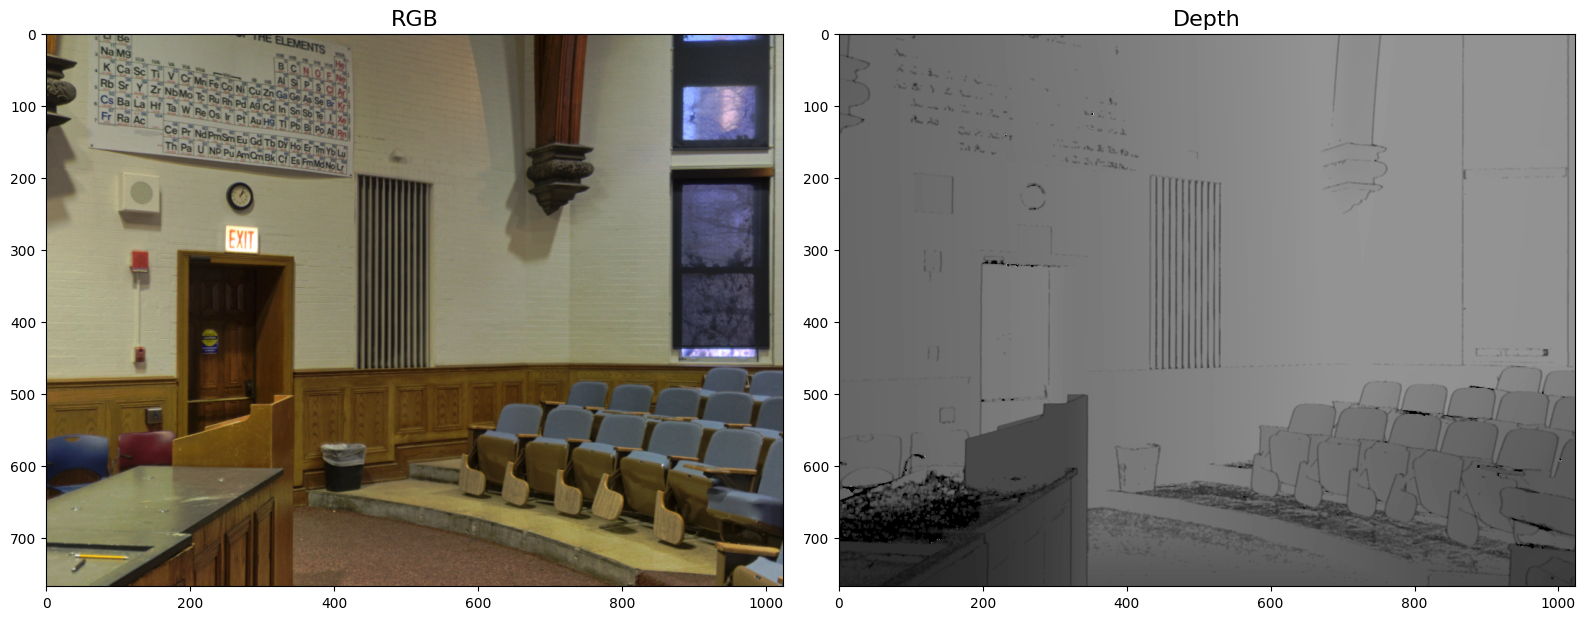

In [7]:
show_rgbd(np.squeeze(groundtruth) * mask , raw_img)

In [8]:
np.unique(np.squeeze(groundtruth) * mask)

array([ 0.       ,  0.9640641,  0.9653691, ..., 17.118383 , 17.59613  ,
       17.830606 ], dtype=float32)

In [9]:
x = (np.squeeze(groundtruth) * mask).flatten()
y = (depth_normalized * mask).flatten()
A = np.vstack([x, np.ones(len(x))]).T

In [10]:
s, t = np.linalg.lstsq(A, y, rcond=None)[0]

In [11]:
depth_aligned = (depth_normalized - t) / s

---- Depth Report ----

Unique values: [ 0.         4.4444575  4.444467  ... 14.025891  14.026116  14.026233 ]
how many uniques: 741331
Max: 14.026232719421387
Min: 0.0
shape: (768, 1024)
Has nan: False
Dtype: float32


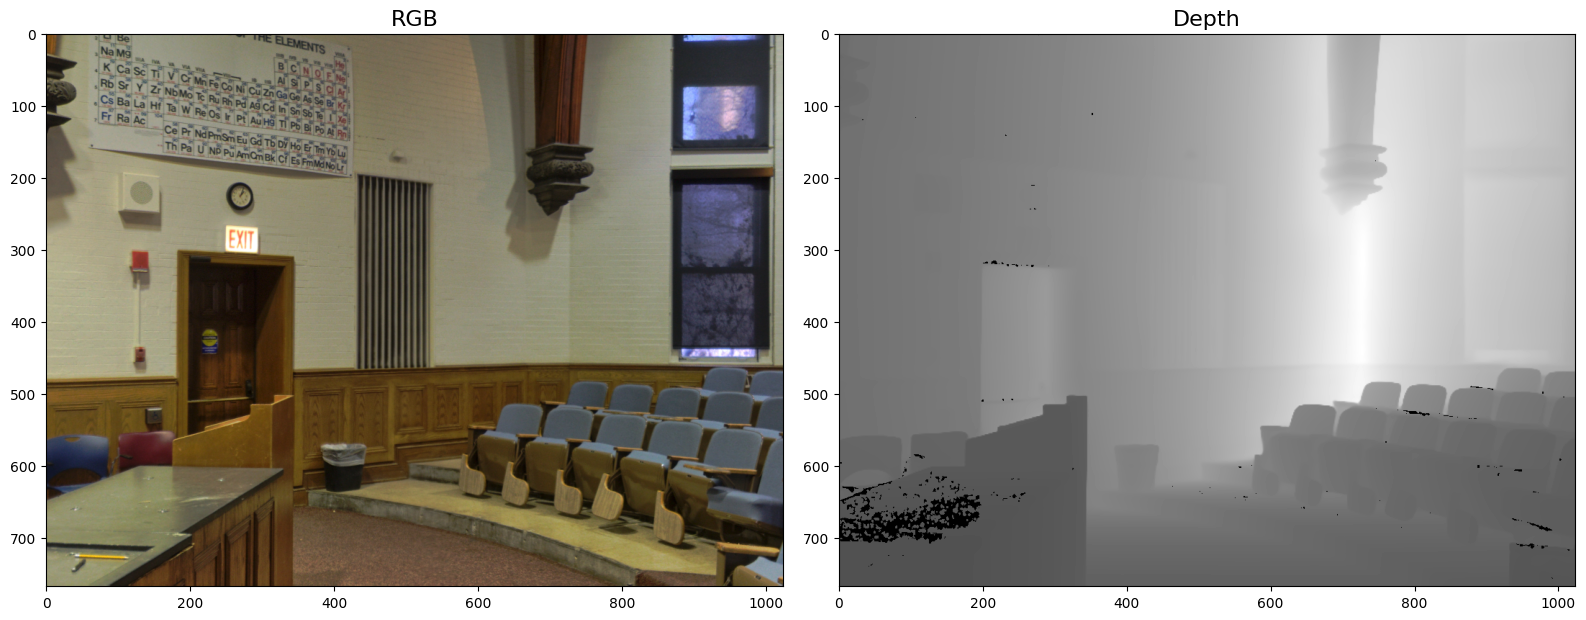

In [12]:
show_rgbd(depth_aligned*mask, raw_img)

# FILENAMES

In [30]:
import glob
import os

diode_path = "/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/"
diode_indoor = "/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/"
diode_outdoor = "/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/outdoor/"
diode_indoor_preds = "/home/gustavo/workstation/depth_estimation/codes/Depth-Anything-V2/output/npy/indoors"
filenames_img = get_sorted_files(diode_indoor, ".png")
filenames_img[:5]

['/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_010.png',
 '/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_040.png',
 '/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_010_000.png',
 '/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_010_020.png',
 '/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_020_030.png']

In [14]:
filenames_depth = get_sorted_files(diode_path, "_depth.npy")
filenames_depth[:5]

['/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_010_depth.npy',
 '/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_040_depth.npy',
 '/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_010_000_depth.npy',
 '/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_010_020_depth.npy',
 '/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_020_030_depth.npy']

In [15]:
filenames_mask = get_sorted_files(diode_path, "_depth_mask.npy")
filenames_mask[:5]

['/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_010_depth_mask.npy',
 '/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_040_depth_mask.npy',
 '/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_010_000_depth_mask.npy',
 '/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_010_020_depth_mask.npy',
 '/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_020_030_depth_mask.npy']

In [37]:
filenames_preds_indoor = get_sorted_files(diode_indoor_preds, ".npy")
filenames_preds_indoor[:5]

['/home/gustavo/workstation/depth_estimation/codes/Depth-Anything-V2/output/npy/indoors/scene_00019/scan_00183/00019_00183_indoors_000_010.png.npy',
 '/home/gustavo/workstation/depth_estimation/codes/Depth-Anything-V2/output/npy/indoors/scene_00019/scan_00183/00019_00183_indoors_000_040.png.npy',
 '/home/gustavo/workstation/depth_estimation/codes/Depth-Anything-V2/output/npy/indoors/scene_00019/scan_00183/00019_00183_indoors_010_000.png.npy',
 '/home/gustavo/workstation/depth_estimation/codes/Depth-Anything-V2/output/npy/indoors/scene_00019/scan_00183/00019_00183_indoors_010_020.png.npy',
 '/home/gustavo/workstation/depth_estimation/codes/Depth-Anything-V2/output/npy/indoors/scene_00019/scan_00183/00019_00183_indoors_020_030.png.npy']

# TEST DIODE DATASET

In [16]:
file_path, subdirectory = os.path.split(filenames_depth[0])
print(file_path)
print(subdirectory)

/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183
00019_00183_indoors_000_010_depth.npy


In [17]:
len(filenames_img)

325

In [ ]:
from depth_anything_v2.dpt import DepthAnythingV2


outdir_npy = "/home/gustavo/workstation/depth_estimation/codes/Depth-Anything-V2/output/npy"
outdir_vis = "/home/gustavo/workstation/depth_estimation/codes/Depth-Anything-V2/output/vis"

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'


model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vitl' # or 'vits', 'vitb', 'vitg'

depth_anything = DepthAnythingV2(**model_configs[encoder])
depth_anything.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_{encoder}.pth', map_location='cpu'))
depth_anything = depth_anything.to(DEVICE).eval()



for k, filename in enumerate(filenames_img[:5]):
        print(f'Progress {k+1}/{len(filenames_img)}: {filename}')
        

        #FOR DIODE ONLY
        output_folder_npy = os.path.join(outdir_npy, "/".join(filename.split("/")[9:12]))
        output_folder_vis = os.path.join(outdir_vis, "/".join(filename.split("/")[9:12]))

        # ISSO TA MT RUIM REFAZER DPS

        if not os.path.exists(output_folder_npy):
             os.makedirs(output_folder_npy)

        if not os.path.exists(output_folder_vis):
            os.makedirs(output_folder_vis)


        raw_image = cv2.imread(filename)
        raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

        
        depth = depth_anything.infer_image(raw_image)
        
        depth_normalized = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
        depth_uint8 = depth_normalized.astype(np.uint8)

        cv2.imwrite(os.path.join(output_folder_vis, os.path.splitext(os.path.basename(filename))[0] + '.png'), depth_uint8)

        np.save(os.path.join(output_folder_npy, os.path.splitext(os.path.basename(filename))[0] + '.png'), depth)

Progress 1/771: /home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_010.png
Progress 2/771: /home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_040.png
Progress 3/771: /home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_010_000.png
Progress 4/771: /home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_010_020.png
Progress 5/771: /home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_020_030.png
Progress 6/771: /home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/scene_00019/scan_00183/00019_00183_indoors_020_050.png
Progress 7/771: /home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val

## TRY CALCULATE ALIGNMENT

In [39]:
index = 50
pred_diode = np.load(filenames_preds_indoor[index])
groundtruth = np.load(filenames_depth[index])
rgb = cv2.imread(filenames_img[index])

---- Depth Report ----

Unique values: [ 83.16467  83.23496  83.32735 ... 374.13425 374.35056 374.37454]
how many uniques: 762615
Max: 374.3745422363281
Min: 83.1646728515625
shape: (768, 1024)
Has nan: False
Dtype: float32


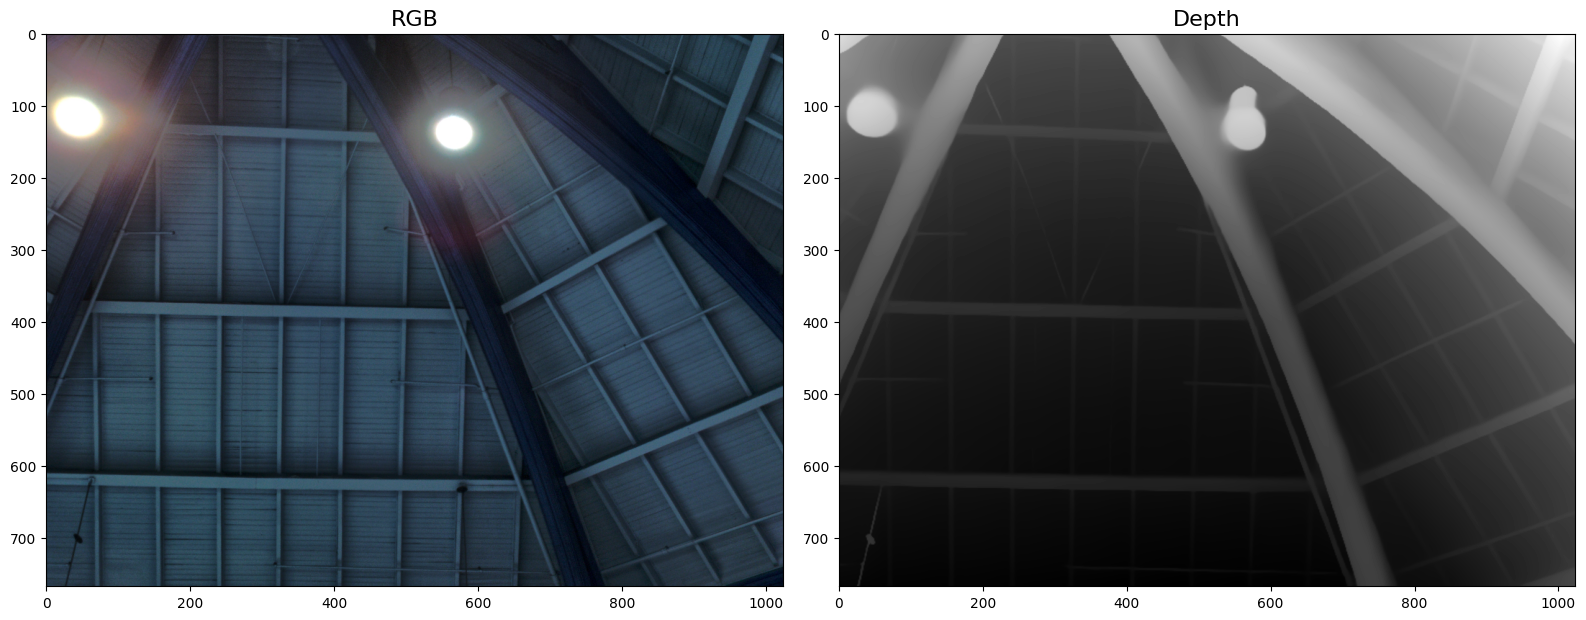

---- Depth Report ----

Unique values: [0.0000000e+00 1.4673784e-02 6.1711218e-02 ... 1.6150833e+02 1.6868692e+02
 1.8666006e+02]
how many uniques: 648741
Max: 186.66006469726562
Min: 0.0
shape: (768, 1024, 1)
Has nan: False
Dtype: float32


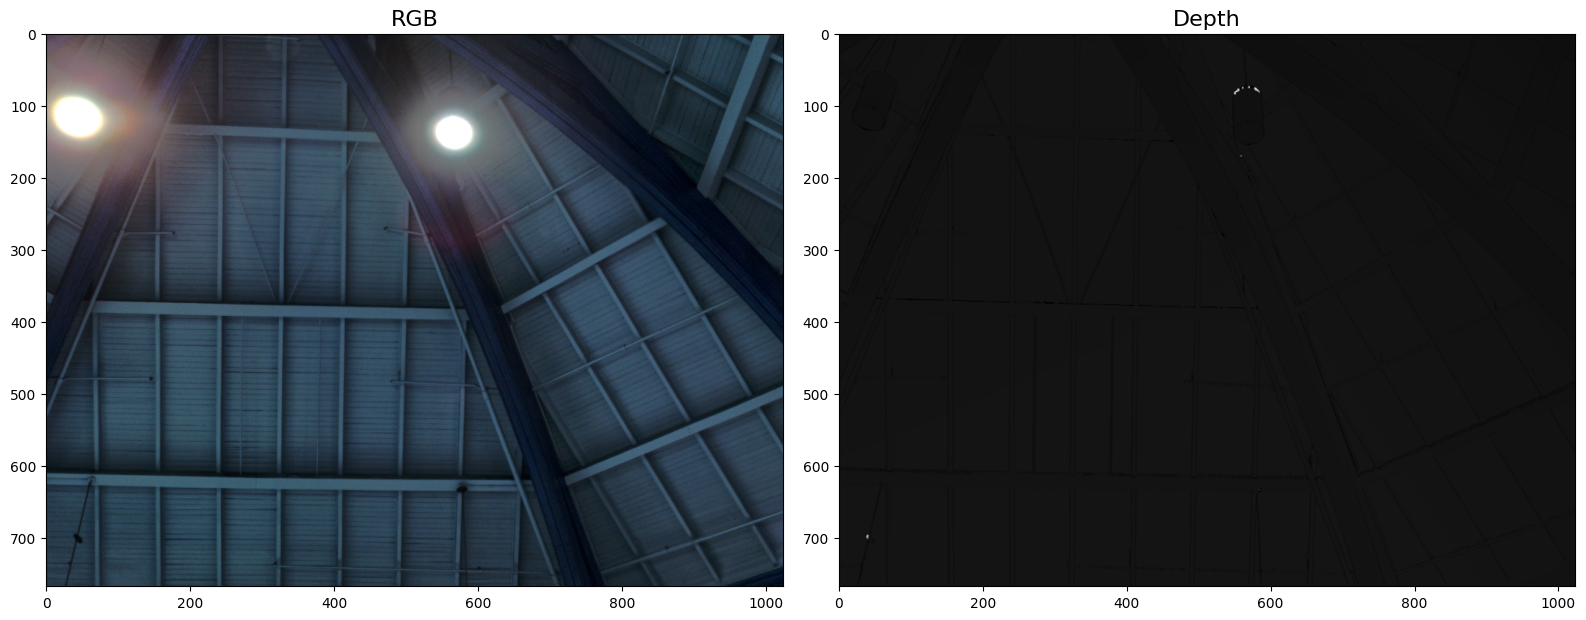

In [42]:
show_rgbd(pred_diode, rgb)
show_rgbd(groundtruth, rgb)

---- Depth Report ----

Unique values: [0.0000000e+00 1.4673784e-02 6.1711218e-02 ... 1.6150833e+02 1.6868692e+02
 1.8666006e+02]
how many uniques: 648741
Max: 186.66006469726562
Min: 0.0
shape: (768, 1024, 1)
Has nan: False
Dtype: float32


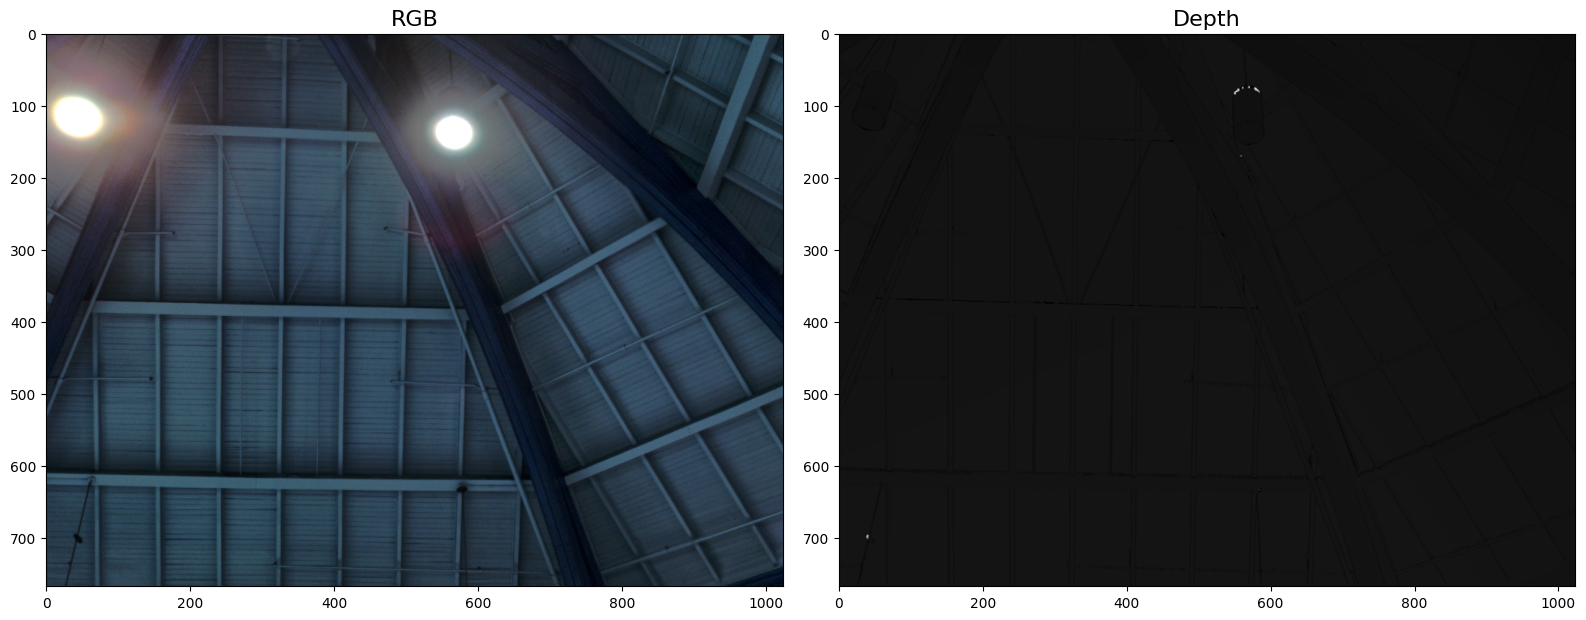

In [41]:
show_rgbd(groundtruth, rgb)

In [63]:
ret, thresh = cv2.threshold(groundtruth, 50, 1, cv2.THRESH_BINARY)

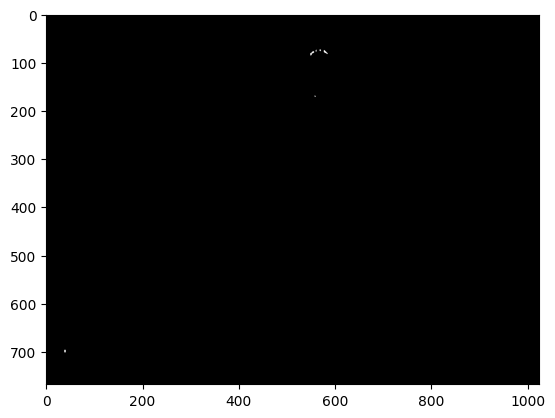

In [64]:
plt.imshow(thresh, cmap="gray")

In [65]:
np.sum(thresh)

98.0